In [1]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNEL = 3

In [2]:
if 'google.colab' in str(get_ipython()):
  isColab = True
else:
  isColab = False

In [3]:
import torch

num_gpu = torch.cuda.device_count()
print(f'{num_gpu} GPU available')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

1 GPU available


In [4]:
import os
from skimage.io import imread, imshow, imread_collection, concatenate_images
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

In [5]:
if isColab:
  from google.colab import files, drive
  if (not 'kaggle.json' in os.listdir()):
    print("Upload kaggle.json")
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
  drive.mount('/content/drive')
  DB_PATH = '/content/drive/MyDrive/scuola/deeplife/'
else:
  print("Check if folder is correct")
  DB_PATH = 'database/extract/stage1_train/'

Check if folder is correct


In [6]:
if os.path.exists(DB_PATH):
    print("Database folder found")
else:
    print(" Generate the database")
    os.makedirs(DB_PATH)
    os.chdir(DB_PATH)
    if(isColab):
        !pip install kaggle
        !kaggle competitions download -c data-science-bowl-2018
        !unzip -q data-science-bowl-2018.zip -d ./
        !unzip -q cellular-segmentation/stage1_train.zip -d unpreocessed/
        if os.path.exists('./cellular-segmentation') and os.path.exists('./data-science-bowl-2018.zip'):
            !rm data-science-bowl-2018.zip
    else:
        print("Download the database and place it in the folder")
    os.chdir('..')

Database folder found


In [7]:
if isColab:
    !pip install opencv-python
    !pip install tqdm
    !pip install pandas

In [8]:
import pandas as pd
# check if the file is present
semapore = False
if os.path.exists(DB_PATH + 'classes.csv'):
    experimental_conditions = pd.read_csv(DB_PATH + 'classes.csv')
    experimental_conditions.head()
    semapore = True

In [9]:
if semapore:
    experimental_conditions.groupby(['foreground', 'background'])['background'].agg('count')
    

Files found in 'images/': 
[WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')]


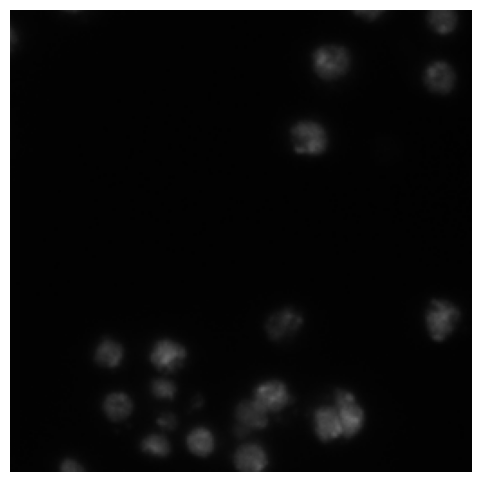


Image dimensions: (256, 256, 4)


In [10]:
from pathlib import Path

TRAIN_DIR = Path(DB_PATH )

observations = os.listdir(TRAIN_DIR)
train_observations = observations[:-60]
sample = train_observations[0]

# for each observation, images/ contains one photo
image_f = sorted((TRAIN_DIR / sample).glob('images/*.png'))
print(f"Files found in 'images/': \n{image_f}")

image = imread(str(image_f[0]))

# plot with matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

print(f'\nImage dimensions: {image.shape}')

Files found in 'masks/': 
[WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png'), WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png'), WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0ea1f9e30124e4aef1407af239ff42fd6f5753c09b4c5cac5d08023c328d7f05.png'), WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0f5a3252d05ecdf453bdd5e6ad5322c454d8ec2d13ef0f0bf45a6f6db45b5639.png'), WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/2c47735510ef91a11fde42b317829cee5fc04d05a797b90008803d7151951d58.png'), WindowsPath('database/extract/stage1_train/

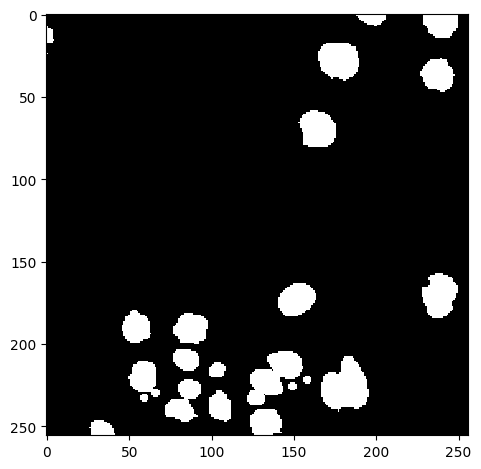

In [11]:
mask_files = sorted((TRAIN_DIR / sample).glob('masks/*.png'))
print(f"Files found in 'masks/': \n{mask_files}")

# insepcting an example of the masks
masks = imread_collection(sorted((TRAIN_DIR / observations[0]).glob('masks/*.png')))
imshow(np.sum(masks, axis=0).astype(np.uint8)) # combine masks 

print(f'\nNumber of masks: {len(masks)}')

In [12]:
from collections import namedtuple

def read_image(observation_id, directory):
    return imread(sorted((directory / observation_id).glob('images/*.png'))[0])

def read_masks(observation_id, directory):
    return imread_collection(sorted((directory / observation_id).glob('masks/*.png')))

# let's get some basic stats about our dataset 
Summary = namedtuple('Summary', ['observation_id', 'image_size', 'n_masks'])
train_data_summary = []

# create data frame of observation_id, image_size, n_masks
for observation_id in train_observations:
    train_data_summary.append(Summary(observation_id=observation_id,
                                      image_size=read_image(observation_id, TRAIN_DIR).shape,
                                      n_masks=len(read_masks(observation_id, TRAIN_DIR))
                                     )
                             )
    
df = pd.DataFrame(train_data_summary, columns=Summary._fields)
df.head()

,observation_id,image_size,n_masks
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"(256, 256, 4)",27
1,003cee89357d9fe13516167fd67b609a164651b2193458...,"(256, 256, 4)",36
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,"(256, 320, 4)",70
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,"(256, 320, 4)",86
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,"(256, 320, 4)",7


In [13]:
df['image_size'].value_counts()

image_size
(256, 256, 4)      296
(256, 320, 4)      104
(360, 360, 4)       86
(520, 696, 4)       86
(1024, 1024, 4)     16
(512, 640, 4)       12
(260, 347, 4)        5
(603, 1272, 4)       4
(1040, 1388, 4)      1
Name: count, dtype: int64

Max height: 534
Image size: (1040, 1388, 4)


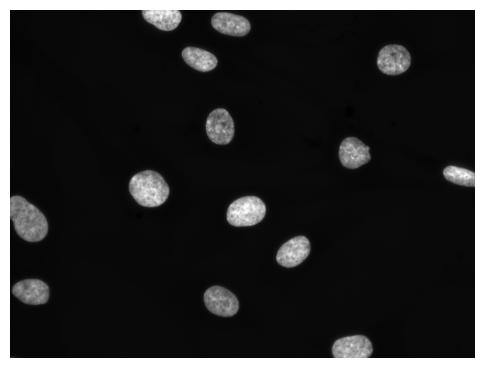

c901794d1a421d52e5734500c0a2a8ca84651fb93b19cec2f411855e70cae339


In [14]:
max_height = df['image_size'].apply(lambda x: x[0]).idxmax()
print(f'Max height: {max_height}')
print(f'Image size: {df.loc[max_height, "image_size"]}')

image = read_image(df.loc[max_height, 'observation_id'], TRAIN_DIR)
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

print( df.loc[max_height].observation_id)

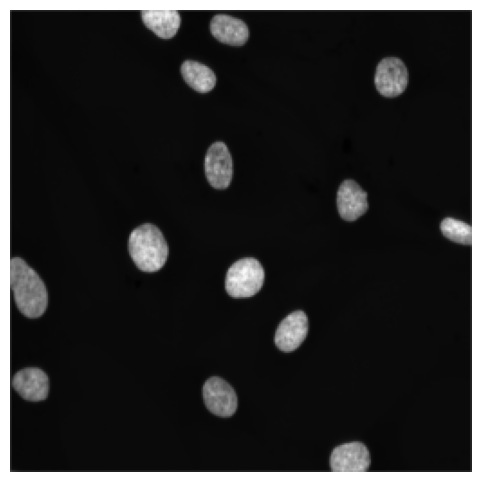

In [15]:
image_resized = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.figure(figsize=(6, 6))
plt.imshow(image_resized.astype(np.uint8))
plt.axis('off')
plt.show()

<Axes: ylabel='Frequency'>

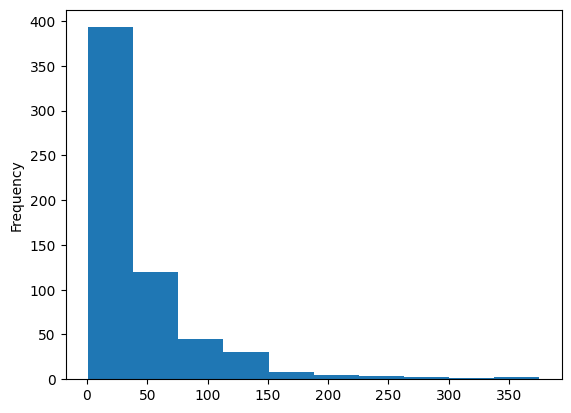

In [16]:
df['n_masks'].plot(kind='hist')